In [61]:
import matplotlib.style
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import h5py # Pour importer le dataset (train_mscale.h5)
import torch.optim as optim
import math
import numpy as np
import matplotlib

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image

matplotlib.style.use('ggplot')

In [62]:
# Paramètres d'apprentissage
batch_size = 64
epochs = 500
learning_rate = 0.001
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'cpu'
)
print(f'Using {device} device')

# Les sous images seront de taille 33x33

Using cuda device


In [63]:
# Paramètres des images
# Images d'entrée
img_height = 33 
img_width = 33
# Images label
out_height = 33
out_width = 33

(21824, 1, 33, 33)
(21824, 1, 33, 33)


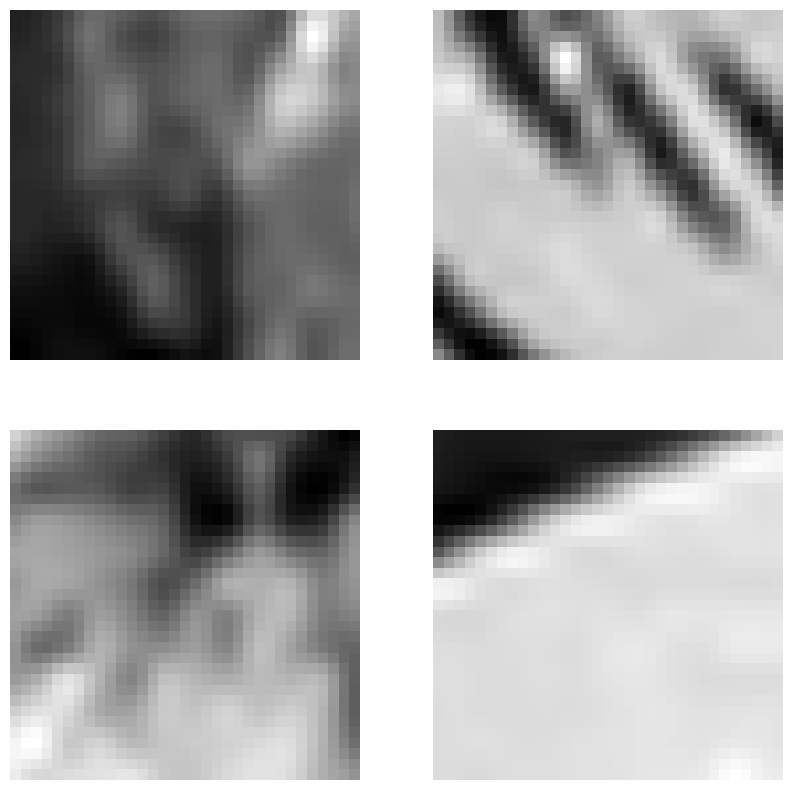

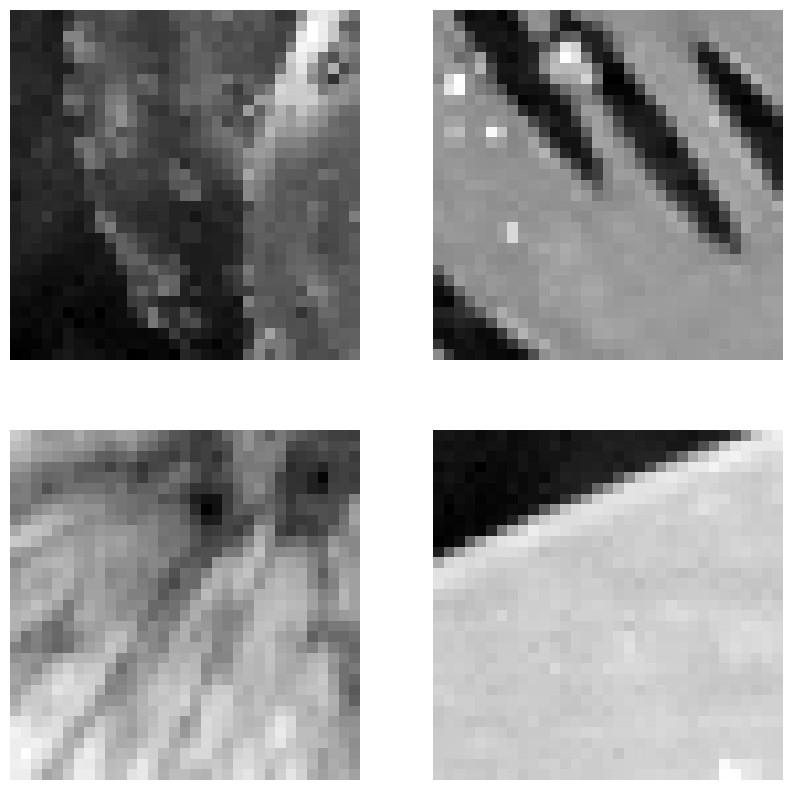

In [64]:
# Préparation des données
file = h5py.File('train_mscale.h5')
# 'in train' est de taille (21884, 33, 33, 1)
in_train = file['data'][:] # images
out_train = file['label'][:] # labels
file.close()

# Normalisation des données et changement de la valeur des pixel en float32 => [0, 1]
in_train = (in_train / 255).astype('float32')
out_train = (out_train / 255).astype('float32')

print(in_train.shape)
print(out_train.shape)

# Plot des images floues
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(in_train[i].reshape(33, 33), cmap='gray')
    plt.axis('off')


# Plot des images nettes
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(out_train[i].reshape(33, 33), cmap='gray')
    plt.axis('off')


In [65]:
# Training and validation split
x_train, x_val, y_train, y_val = train_test_split(
    in_train, out_train, test_size=0.25
)
print(x_train.shape)
print(x_val.shape)

(16368, 1, 33, 33)
(5456, 1, 33, 33)


In [66]:
# Création du modèle
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN().to(device)
print(model)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [67]:
# optimizer
omptimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Fonction de coût
criterion = nn.MSELoss()

In [68]:
# Le module de dataset
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.images = image_data
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [69]:
# Initialisation des datasets
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)

# Initialisation des dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [70]:
# Fonction PSNR pour évaluer la qualité de l'image
def PSNR(label, outputs, max_val=1.):
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else :
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [71]:
# Fonction d'entraînement
def train(model, dataLoader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    
    for bi, data in tqdm(enumerate(dataLoader), total=int(len(train_data) / dataLoader.batch_size)):
        image_data = data[0].to(device)
        labels = data[1].to(device)

        omptimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, labels)

        loss.backward()

        omptimizer.step()

        running_loss += loss.item()

        batch_psnr = PSNR(labels, outputs)
        running_psnr += batch_psnr

    final_loss = running_loss / len(dataLoader.dataset)
    final_psnr = running_psnr / int(len(train_data) / dataLoader.batch_size)
    return final_loss, final_psnr

In [72]:
# Fonction de validation
def validate(model, dataLoader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0

    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataLoader), total=int(len(val_data) / dataLoader.batch_size)):
            image_data = data[0].to(device)
            labels = data[1].to(device)

            outputs = model(image_data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            batch_psnr = PSNR(labels, outputs)
            running_psnr += batch_psnr

        outputs = outputs.cpu()
        save_image(outputs, f"outputs/val_sr_{epoch}.png")

    final_loss = running_loss / len(dataLoader.dataset)
    final_psnr = running_psnr / int(len(val_data) / dataLoader.batch_size)
    return final_loss, final_psnr

In [73]:
# Entraînement et validation
train_loss = []
train_psnr = []
val_loss = []
val_psnr = []
start = time.time()

for epoch in tqdm(range(epochs)):
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)

end = time.time()
print(f"Training time: {end - start}s")

256it [00:01, 218.39it/s]                         
86it [00:00, 529.33it/s]                        
256it [00:00, 265.90it/s]                         
86it [00:00, 545.05it/s]                        
256it [00:00, 260.34it/s]                         
86it [00:00, 515.67it/s]                        
256it [00:00, 268.43it/s]                         
86it [00:00, 540.82it/s]                        
256it [00:00, 272.52it/s]                         
86it [00:00, 543.40it/s]                        
256it [00:00, 272.14it/s]                         
86it [00:00, 542.82it/s]                        
256it [00:00, 270.52it/s]                         
86it [00:00, 556.70it/s]                        
256it [00:01, 242.32it/s]                         
86it [00:00, 411.27it/s]                        
256it [00:01, 237.06it/s]                         
86it [00:00, 420.83it/s]                        
256it [00:01, 229.55it/s]                         
86it [00:00, 396.71it/s]                        


Training time: 554.302149772644s


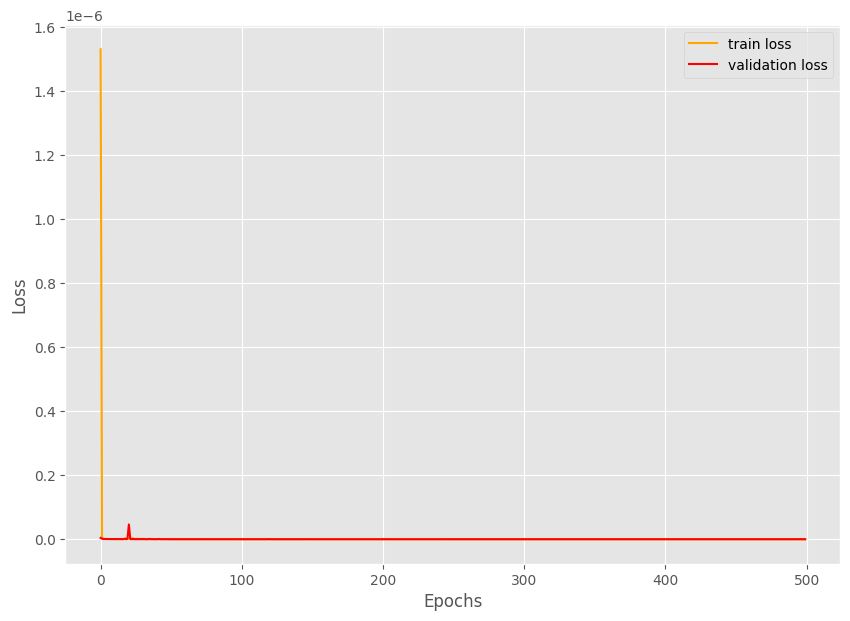

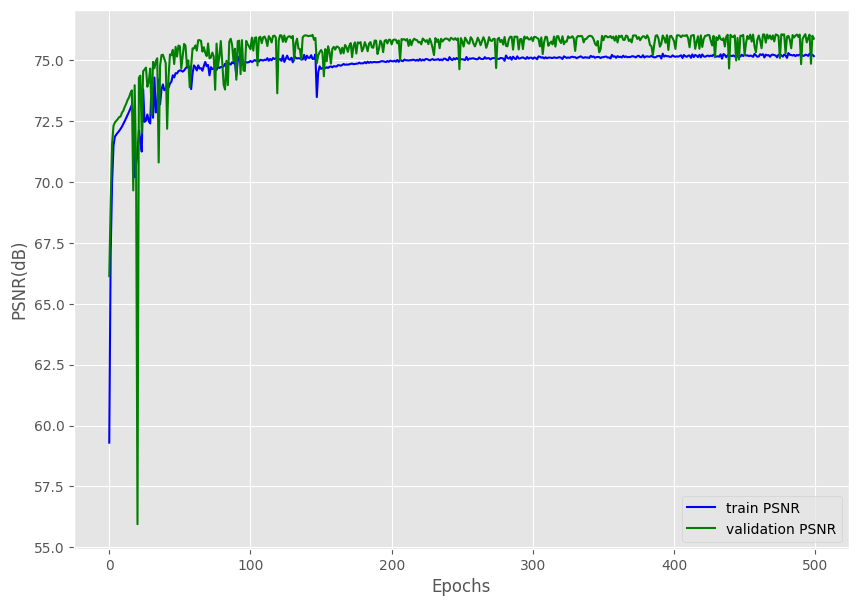

In [74]:
# Tracé des résultats
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot PSNR
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='blue', label='train PSNR')
plt.plot(val_psnr, color='green', label='validation PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR(dB)')
plt.legend()
plt.show()

In [75]:
# Sauvegarde du modèle
print("Saving model...")
torch.save(model.state_dict(), 'outputs/sr_model.pth')

Saving model...


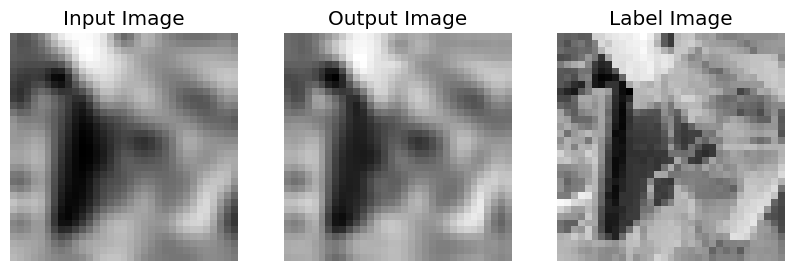

In [77]:
# Test du modèle
model.eval()
test_image = x_val[20]
test_label = y_val[20]
test_image = torch.tensor(test_image, dtype=torch.float).to(device)
test_label = torch.tensor(test_label, dtype=torch.float).to(device)
output = model(test_image)
output = output.cpu().detach().numpy()
output = output.reshape(33, 33)
test_image = test_image.cpu().detach().numpy()
test_image = test_image.reshape(33, 33)
test_label = test_label.cpu().detach().numpy()
test_label = test_label.reshape(33, 33)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(output, cmap='gray')
plt.title('Output Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(test_label, cmap='gray')
plt.title('Label Image')
plt.axis('off')
plt.show()
